## Context: Music Discovery and Personalization
Streaming music is now mainstream, fans have unprecedented music access, making personalized music discovery more important than ever. The world’s leading digital music services rely on creating unique taste profiles for their users in order to make playlists more personal, recommendations more relevant, and discovery more social.

However, the current recommendation systems that are based on listeners who listen to similar artists is only effective for major artists with an extensive fan following and largely miscategorizes new creators. Incorporating a new Recommendation System based off of similar audio properties, rather than the listeners, in order to cluster similar styles together, can help compensate for this discrepancy.


## Goal: Recommend music genres based on similarities of music audio characteristics.

**Personal Playlisting**
- predictive playlists that get smarter over time with machine learning and end-user tuning
- predictive playlisting that adjusts acoustically to each fan’s taste and context digital understanding of each
- individual’s personal music taste -> captures live playback behavior (artist plays, song plays, seeds, skips, bans, favorites, and more) and uses it to personalize playlists, radio, and the rest of the discovery experience.

## Acknowledgements
This work is a simplification from the Kaggle dataset posted at https://www.kaggle.com/grasslover/spotify-music-genre-list#songDb.tsv and the work of The Echo Nest at http://the.echonest.com/, https://www.kaggle.com/c/msdchallenge, the pyAudioAnalysis at https://github.com/tyiannak/pyAudioAnalysis/wiki, and SoundScrape at https://github.com/Miserlou/SoundScrape to create the dataset from Soundcloud artists.

### Watermark Extension
- Documentation of when program was run and with which packages

In [2]:
# install watermark extension
!pip install --upgrade pip
!pip install watermark

    100% |████████████████████████████████| 1.4MB 17.8MB/s ta 0:00:01
  Found existing installation: pip 19.0.3
    Uninstalling pip-19.0.3:
      Successfully uninstalled pip-19.0.3


In [4]:
# Use a future note
%load_ext watermark

### Workflow for Using Machine Learning in Predictive Modeling:
**1. Preprocessing: Preparation of Data for Modeling**
    - Labels / Raw Data
    - Convertion of String Data into Binary Numerical Values
    - Convertion of Binary Numerical Data into Vectors
    - Convertion of Vector Columns into Combined Vectors
    - Pipelining of Data
**3. Learning**
    - Transformation and Fit of Data to Pipeline
    - Splitting of Training and Testing Data
    - Learning Algorithm
        - Model Selection
        - Cross-Validation
        - Create and Test Grid of Performance Metrics (Hyperparameters)
        - Hyperparameter Optimization
**4. Evaluation** 
    - Final Model
    - Labels Prediction Accuracy
**5. Prediction**
    - New Data
    - Label Predictions

In [1]:
# Import the relevant python libraries for the analysis
import pandas as pd
from pandas import DataFrame
import numpy as np
import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import pylab as pl

# Recommending System
%run Recommenders.ipynb
import networkx as nx

In [6]:
%watermark -a "Emily Schoof" -d -t -v -p numpy,pandas,seaborn,matplotlib,sklearn -g 

Emily Schoof 2019-06-13 17:25:11 

CPython 3.7.3
IPython 7.4.0

numpy 1.16.2
pandas 0.24.2
seaborn 0.9.0
matplotlib 3.0.3
sklearn 0.20.3
Git hash:


#### Requirements Text

In [7]:
# Install requirements.txt
!pip install -r requirements.txt

In [6]:
# %prun -> displays report of how time was run for that function- spot inefficient pieces of code
# export python notebook to just python files: bit.ly/py-html-config
# http://www.waffle.io

## Creating a Personalized Recommendation System

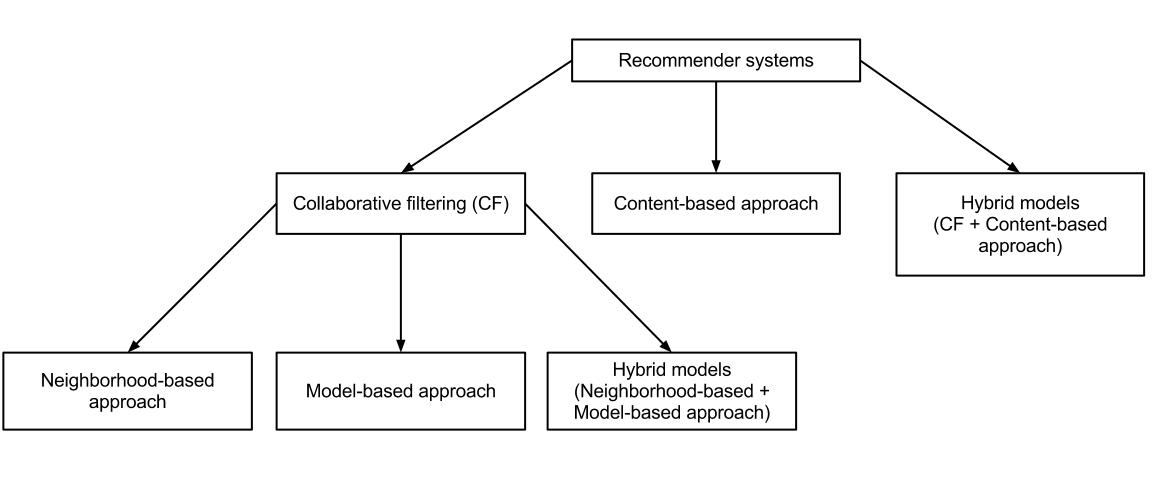

In [7]:
from IPython.display import Image
Image(filename='data/RecommendationSystems.jpg')

## Section 1: Preprocessing and Exploratory Analysis¶
- Load and Clean SongDb.tsv dataset
- Visualize Data

### A. Load Genre Audio Categories and Clean Data

In [2]:
# Load SongDb.tsv dataset - convert .tsv file to .csv for uploading
file_encoding = 'utf8'
input_fd = open('data/songDb.tsv', encoding=file_encoding, errors='backslashreplace')
beats = pd.read_csv(input_fd, delimiter='\t', low_memory=False)
beats.head()

,Name,Danceability,Energy,Key,Loudness,Mode,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Type,ID,Uri,Ref_Track,URL_features,Duration_ms,time_signature,Genre
0,YuveYuveYu,0.624,0.857,10.0,-6.250,0.0,0.0542,0.020800,0.206000,0.110,0.324,131.926,audio_features,6J2VvzKwWc2f0JP5RQVZjq,spotify:track:6J2VvzKwWc2f0JP5RQVZjq,https://api.spotify.com/v1/tracks/6J2VvzKwWc2f...,https://api.spotify.com/v1/audio-analysis/6J2V...,282920.0,4.0,celticmetal
1,Gloryhammer,0.517,0.916,0.0,-4.933,1.0,0.0559,0.000182,0.001910,0.306,0.444,135.996,audio_features,4HA34COgxgVJ6zK88UN4Ik,spotify:track:4HA34COgxgVJ6zK88UN4Ik,https://api.spotify.com/v1/tracks/4HA34COgxgVJ...,https://api.spotify.com/v1/audio-analysis/4HA3...,300320.0,4.0,celticmetal
2,Nostos,0.251,0.894,8.0,-4.103,0.0,0.0570,0.014400,0.000000,0.123,0.297,114.223,audio_features,3W6Xik6Xxf06JuUoZSATlD,spotify:track:3W6Xik6Xxf06JuUoZSATlD,https://api.spotify.com/v1/tracks/3W6Xik6Xxf06...,https://api.spotify.com/v1/audio-analysis/3W6X...,175353.0,4.0,celticmetal
3,Yggdrasil,0.469,0.743,1.0,-5.570,0.0,0.0272,0.002220,0.000111,0.276,0.481,86.953,audio_features,2gGveBaLJQMtJ43X4UL5kH,spotify:track:2gGveBaLJQMtJ43X4UL5kH,https://api.spotify.com/v1/tracks/2gGveBaLJQMt...,https://api.spotify.com/v1/audio-analysis/2gGv...,272292.0,4.0,celticmetal
4,Incense&Iron,0.487,0.952,1.0,-4.429,0.0,0.0613,0.000228,0.000000,0.161,0.329,125.993,audio_features,1lRF81A1C9QoCgBcEop2zg,spotify:track:1lRF81A1C9QoCgBcEop2zg,https://api.spotify.com/v1/tracks/1lRF81A1C9Qo...,https://api.spotify.com/v1/audio-analysis/1lRF...,237933.0,4.0,celticmetal


In [11]:
# List # of column, # of unique Genres, and total row length of dataset
len(beats.columns), len(beats.Genre.unique()), len(beats)

(20, 626, 131580)

In [12]:
# List column names
list(beats.columns)

['Name',
 'Danceability',
 'Energy',
 'Key',
 'Loudness',
 'Mode',
 'Speechness',
 'Acousticness',
 'Instrumentalness',
 'Liveness',
 'Valence',
 'Tempo',
 'Type',
 'ID',
 'Uri',
 'Ref_Track',
 'URL_features',
 'Duration_ms',
 'time_signature',
 'Genre']

#### Assess Data Cleanliness: Drop all rows with NaN values and Drop Unnecessary Information

In [13]:
beats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131580 entries, 0 to 131579
Data columns (total 20 columns):
Name                131578 non-null object
Danceability        131580 non-null float64
Energy              131580 non-null float64
Key                 131580 non-null float64
Loudness            131580 non-null float64
Mode                131580 non-null float64
Speechness          131580 non-null float64
Acousticness        131580 non-null float64
Instrumentalness    131580 non-null float64
Liveness            131580 non-null float64
Valence             131580 non-null float64
Tempo               131580 non-null object
Type                131580 non-null object
ID                  131580 non-null object
Uri                 131580 non-null object
Ref_Track           131580 non-null object
URL_features        131580 non-null object
Duration_ms         131580 non-null float64
time_signature      131580 non-null object
Genre               131554 non-null object
dtypes: float64(11

In [54]:
beats.head(1)

,Name,Danceability,Energy,Key,Loudness,Mode,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Type,ID,Uri,Ref_Track,URL_features,Duration_ms,time_signature,Genre
0,YuveYuveYu,0.624,0.857,10.0,-6.25,0.0,0.0542,0.0208,0.206,0.11,0.324,131.926,audio_features,6J2VvzKwWc2f0JP5RQVZjq,spotify:track:6J2VvzKwWc2f0JP5RQVZjq,https://api.spotify.com/v1/tracks/6J2VvzKwWc2f...,https://api.spotify.com/v1/audio-analysis/6J2V...,282920.0,4.0,celticmetal


#### Necessary Adjustments to Data:
1. Drop all columns with NaN values
2. Convert numerical strings to numerical floats
    - Tempo
    - time_signature
3. Drop unnecessary columns
    - Name
    - ID
    - Uri
    - Ref_Track
    - URL_features
    - Type

In [3]:
# Drop NaN values
beats = beats.dropna()

# Convert column values to numbers
beats['Tempo'] = pd.to_numeric(beats['Tempo'])
beats['time_signature'] = pd.to_numeric(beats['time_signature'])

# Drop unnecessary columns
beats = beats.drop(['Name','ID','Uri','Ref_Track','URL_features','Type'], axis=1)

In [96]:
# Test output
beats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131552 entries, 0 to 131579
Data columns (total 14 columns):
Danceability        131552 non-null float64
Energy              131552 non-null float64
Key                 131552 non-null float64
Loudness            131552 non-null float64
Mode                131552 non-null float64
Speechness          131552 non-null float64
Acousticness        131552 non-null float64
Instrumentalness    131552 non-null float64
Liveness            131552 non-null float64
Valence             131552 non-null float64
Tempo               131552 non-null float64
Duration_ms         131552 non-null float64
time_signature      131552 non-null float64
Genre               131552 non-null object
dtypes: float64(13), object(1)
memory usage: 15.1+ MB


### B. Visualize Data
- Use a Scatterplot Matrix to visualize pair-wise correlations between different features in the dataset in one place

#### Assessing Correlation of Co-Efficients

In [4]:
# Create a correlation dataframe
feature_corr = beats.corr()
feature_corr

,Danceability,Energy,Key,Loudness,Mode,Speechness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Duration_ms,time_signature
Danceability,1.000000,0.085840,0.028094,0.184340,-0.058505,0.128191,-0.133814,-0.176338,-0.096899,0.466527,-0.084355,-0.090894,0.169391
Energy,0.085840,1.000000,0.030325,0.777078,-0.028915,0.105022,-0.722825,-0.159389,0.183757,0.231796,0.227372,-0.012322,0.160863
Key,0.028094,0.030325,1.000000,0.018524,-0.166464,0.026550,-0.027710,0.001603,-0.002285,0.023278,0.003781,0.010581,0.012753
Loudness,0.184340,0.777078,0.018524,1.000000,-0.012096,0.042177,-0.601857,-0.371484,0.110873,0.236044,0.174872,-0.095715,0.148544
Mode,-0.058505,-0.028915,-0.166464,-0.012096,1.000000,-0.046509,0.039739,-0.047964,0.008585,0.026513,0.018149,-0.045754,-0.020023
Speechness,0.128191,0.105022,0.026550,0.042177,-0.046509,1.000000,-0.006039,-0.115895,0.185406,0.035008,0.011056,0.047948,-0.004907
Acousticness,-0.133814,-0.722825,-0.027710,-0.601857,0.039739,-0.006039,1.000000,0.115110,-0.083420,-0.084511,-0.189845,-0.062050,-0.171251
Instrumentalness,-0.176338,-0.159389,0.001603,-0.371484,-0.047964,-0.115895,0.115110,1.000000,-0.075751,-0.298873,-0.007171,0.225852,-0.067023
Liveness,-0.096899,0.183757,-0.002285,0.110873,0.008585,0.185406,-0.083420,-0.075751,1.000000,-0.001384,0.023978,0.013702,-0.001314
Valence,0.466527,0.231796,0.023278,0.236044,0.026513,0.035008,-0.084511,-0.298873,-0.001384,1.000000,0.049407,-0.236994,0.104475


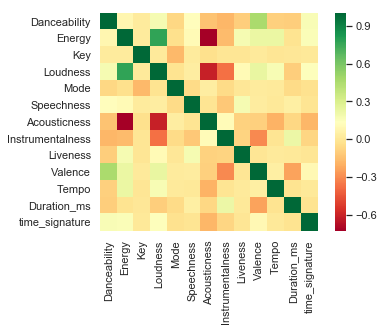

In [5]:
# Plot a correlation heatmap
sns.heatmap(feature_corr, square=True, cmap='RdYlGn')

*Observations*: It appears that the strongest correlations are between **Energy and Loudness (+0.752046)** followed by **Energy and Acousticness (-0.697046)**, **Loudness and Acousticness (-0.601911)**, **Danceability and Valence (+0.466527)**, and a weaker, but still notable, correlation between **Loudness and Instrumentalness (-0.371383)**.

## Section 2: Preparation of Data for Modeling

### Encode Categorical Data into Numberical Data
- Where every observation of a given feature has a unique vector which al l elements are 0 aside from one value of 1, which corresponds to vector level
- Step-by-Step process sourced from: https://www.ritchieng.com/machinelearning-one-hot-encoding/

In [6]:
# Import necessary modules
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [7]:
# Limit to categorical data using df.select_dtypes()
categorical_genres = beats.select_dtypes(include=[object])
categorical_genres.tail(3)

,Genre
131577,britishindierock
131578,britishindierock
131579,britishindierock


In [8]:
# Check data shape
categorical_genres.shape

(131552, 1)

#### Create a LabelEncoder object and fit it to each feature in categorical_genres

In [10]:
# Encode labels with value between 0 and n_classes-1
le = LabelEncoder()

# Fit/Transform data user df.apply() on le.fit_transform to all columns
genres_encoded = categorical_genres.apply(le.fit_transform)
genres_encoded.head()

,Genre
0,81
1,81
2,81
3,81
4,81


In [11]:
genres_encoded.tail()

,Genre
131575,66
131576,66
131577,66
131578,66
131579,66


#### Transform categorical_encoded integers into Binary values

In [12]:
# Encode categorical integer features and fit to data
ohe = OneHotEncoder(handle_unknown='ignore').fit(genres_encoded)

# Transform data
onehotlabels = ohe.transform(genres_encoded).toarray()
onehotlabels.shape

(131552, 625)

In [13]:
# Test output
onehotlabels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
# Convert onehotlabels to dataframe
binary_genres = pd.DataFrame()
binary_genres['vector_genres'] = pd.Series(onehotlabels)
binary_genres.head(1)

Exception: Data must be 1-dimensional

### Pipeline Data
- Reduce the dimension of the feature space in such a way that new variables are orthogonal to each other
- Source code: https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60
- **Target Variable = Genre**

In [15]:
# Import necessary modules
from sklearn.preprocessing import StandardScaler

#### 1. Standard Scaler
- Standardize the dataset’s features onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of machine learning algorithms

In [16]:
beats.columns

Index(['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Duration_ms', 'time_signature', 'Genre'],
      dtype='object')

In [18]:
# Define the features of beats
features = ['Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Duration_ms', 'time_signature', ]

# Separate out the features
feature_x = beats.loc[:, features].values

# Separate out the target
target_y = beats.loc[:,['Genre']].values

# Standardizing the features
standard_x = StandardScaler().fit_transform(feature_x)

In [19]:
# Test output
standard_x

array([[ 0.38444802,  0.85049056,  1.31423592, ...,  0.34576344,
         0.23254216,  0.23302161],
       [-0.20129677,  1.09062019, -1.49032696, ...,  0.48604661,
         0.3710963 ,  0.23302161],
       [-1.65744737,  1.00108033,  0.75332334, ..., -0.26441666,
        -0.6240011 ,  0.23302161],
       ...,
       [-1.54248811,  1.09876018,  1.5946922 , ...,  0.60937172,
        -0.74922537,  0.23302161],
       [-0.83083556,  1.03364028, -0.08804552, ...,  0.51661938,
        -0.63116769,  0.23302161],
       [-0.39289553,  0.77723068, -0.64895809, ...,  1.86723268,
         0.03984043,  0.23302161]])

#### 2. PCA Projection to 2D
- Dimensionality reduction of principal components to 2.

In [20]:
# Import necessary modules
from sklearn.decomposition import PCA

In [21]:
# Create a Principle Component instance with 2 principle components
pca = PCA(n_components=2)

# Fit to standardized data
principal_components = pca.fit_transform(standard_x)

# Create a dataframe for the principle components
principal_df = pd.DataFrame(data=principal_components, 
                            columns=['principal_component_1', 'principal_component_2'])
principal_df.head()

,principal_component_1,principal_component_2
0,-1.030272,0.716061
1,-1.492730,0.870674
2,-1.007227,1.174638
3,-0.800711,0.324900
4,-1.413238,0.879780


#### Concatenate Binary Response Variable of Genres,'onehotlabels', to principal components dataframe

In [28]:
# Concatenate DataFrames before plotting the data
genre_principals = pd.concat(principal_df, binary_genres)
genre_principals.head()

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [23]:
genre_principals = genre_principals.dropna()

In [24]:
# Determine the numbers of Genre
len(list(genre_principals.Genre.unique()))

625

#### Visualize Data

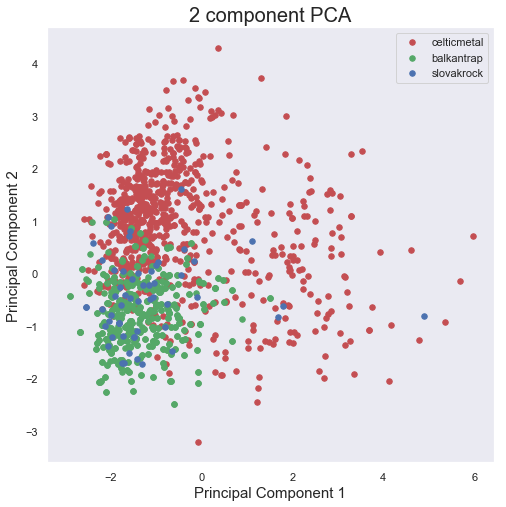

In [25]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = genre_principals.Genre.unique()
colors = ['r', 'g', 'b']

for target, color in zip(targets, colors):
    indices_to_keep = genre_principals['Genre'] == target
    ax.scatter(genre_principals.loc[indices_to_keep, 'principal_component_1'], 
               genre_principals.loc[indices_to_keep, 'principal_component_2'], 
               c = color, 
               s = 30)
ax.legend(targets)
ax.grid()

#### Explained Variance

In [161]:
pca.explained_variance_ratio_

array([0.21918498, 0.12409449])

#### Load User Data
- consists of triplets 
    - user ID
    - song ID 
    - play count

In [ ]:
# Load SongDb.tsv dataset - convert .tsv file to .csv for uploading
music_user = open('data/train_triplets.txt')
music_user = music_user.read()
music_user

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


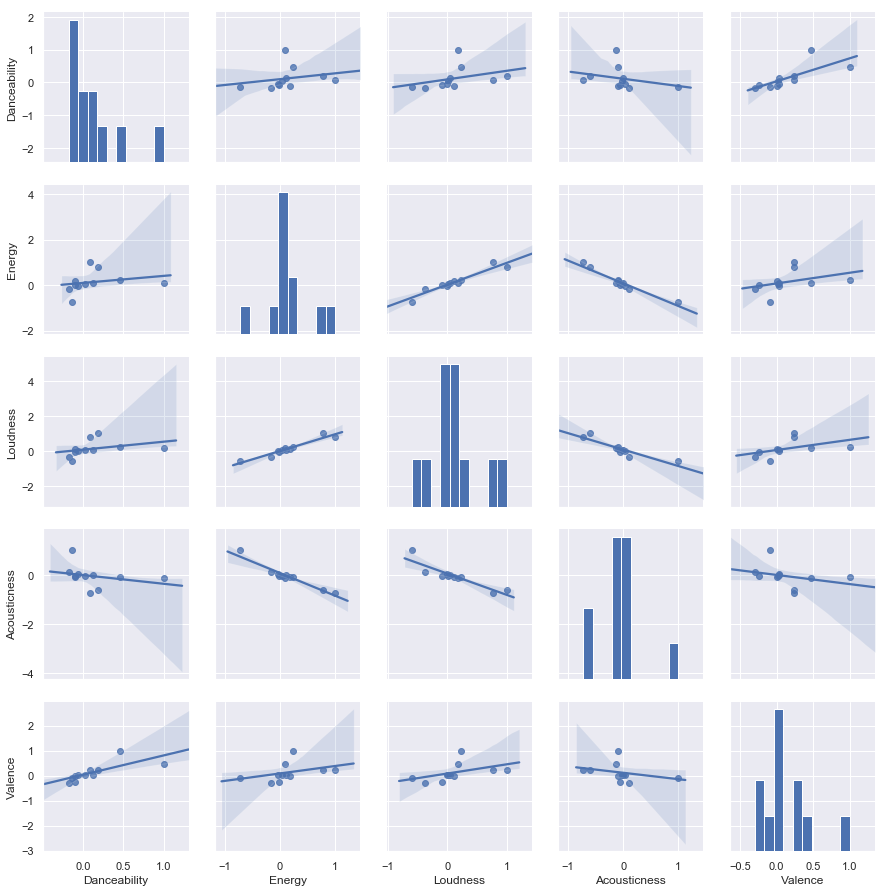

In [28]:
sns.pairplot(data=feature_corr[['Danceability', 'Energy', 'Loudness', 
                              'Acousticness','Valence']], kind="reg")

## Part 2: Learning
- Model Selection
    - Cross-Validation
    - Performance Metrics
    - Hyperparameter Optimization

#### Testing and Training Data

In [164]:
train_data, test_data = train_test_split(genre_principals, test_size=0.20, random_state=0)
train_data.head(5)

,principal_component_1,principal_component_2,Genre
49978,-1.353764,-1.150608,danishpoprock
108000,1.641677,-1.737836,cornwallindie
81579,3.760017,-0.084467,deepsoundtrack
45304,-1.022494,-0.580343,volksmusik
46052,-0.867436,-1.027483,nuelectro


#### Further Split Training Data into Train and Test sets

In [167]:
# Entire dataset (even with response variable)
X = train_data.copy().drop(columns=['Genre'])

# The response variable
y = train_data.copy().pop('Genre')

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(73653, 31566, 73653, 31566)

In [175]:
def plot_decision_regions(X, y, classifier, resolution=0.2):
    
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # plot class samples
    for idx, c1 in enumerate(np.unique(y)):
        plt.scatter(x=X[y == c1, 0],
                    y=Y[ y == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=c1,
                    edgecolor='black')

#### Decision Tree Classifier

In [170]:
# Import necessary modules
from sklearn.tree import DecisionTreeClassifier

In [171]:
# Create a tree instance
tree = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)

# Fit data to tree
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [ ]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, classifier=tree)

#### K- Nearest Neighbors

In [34]:
# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering

In [35]:
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

In [ ]:
plot_decision_regions(X, y, classifier=knn)

#### K-fold Cross-Validation
- Split Training Data into Various Groups for Cross-Validation

In [36]:
# scikit-learn k-fold cross-validation
from numpy import array
from sklearn.model_selection import KFold

# prepare cross validation
kfold = KFold(n_splits=5, shuffle=True, random_state=9)

# create a dataframe to hold training and testing data from splits
kfold_splits = pd.DataFrame(columns=['Split Number','X_train', 'X_test', 'y_train', 'y_test', 'knn', 'kparams','kneighbors', 'kpredict', 'kscore'])
kfold_splits

,Split Number,X_train,X_test,y_train,y_test,knn,kparams,kneighbors,kpredict,kscore


In [37]:
i = 0

# enumerate splits
for train_index, test_index in kfold.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    i += 1
    # add row to kfolds dataframe
    kfold_splits = kfold_splits.append({'Split Number':i , 
                         'X_train':X_train, 
                         'X_test':X_test, 
                         'y_train':y_train, 
                         'y_test':y_test, 
                         'knn':np.nan,
                         'kparams':np.nan,
                         'kneighbors':np.nan,
                         'kpredict':np.nan,
                         'kscore':np.nan}, ignore_index=True)

TRAIN: [     0      1      2 ... 105238 105239 105240] TEST: [    12     14     24 ... 105226 105235 105237]
TRAIN: [     0      1      2 ... 105237 105239 105240] TEST: [     4      8     11 ... 105233 105234 105238]
TRAIN: [     0      1      4 ... 105238 105239 105240] TEST: [     2      3      7 ... 105220 105231 105232]
TRAIN: [     2      3      4 ... 105237 105238 105240] TEST: [     0      1      5 ... 105227 105230 105239]
TRAIN: [     0      1      2 ... 105237 105238 105239] TEST: [     6     10     35 ... 105228 105236 105240]


In [38]:
# Create fold instance to fit 
for split in kfold_splits['Split Number']:
    idx = split - 1
    X_train, X_test = kfold_splits['X_train'].loc[idx], kfold_splits['X_test'].loc[idx]
    y_train, y_test = kfold_splits['y_train'].loc[idx], kfold_splits['y_test'].loc[idx]
    
    # Fit the classifier to the data
    knn = knn.fit(X_train,y_train)
    kparams = knn.get_params()
    kneighbors = knn.kneighbors()
    
    # Test model prediction and accuracy
    kpredict = knn.predict(X_test)
    kscore = knn.score(X_test, y_test)
    
    # Add to dataframe
    kfold_splits.at[idx, 'knn'] = knn
    kfold_splits.at[idx, 'kparams'] = kparams
    kfold_splits.at[idx, 'kneighbors'] = kneighbors
    kfold_splits.at[idx, 'kpredict'] = kpredict
    kfold_splits.at[idx, 'kscore'] = kscore
    print(idx)

0
1
2
3
4


In [39]:
# Test output
kfold_splits

,Split Number,X_train,X_test,y_train,y_test,knn,kparams,kneighbors,kpredict,kscore
0,1,Name Danceability Energy Loudness...,Name Danceability Energy Loudness ...,128101 441 74486 91 117692 622 9504...,69486 531 114918 525 104221 414 7925...,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'leaf_size': 30, 'metric...","([[2.32551719838835, 3.2078500588400334, 4.194...","[275, 52, 574, 89, 9, 532, 6, 545, 235, 347, 2...",0.0785786
1,2,Name Danceability Energy Loudness...,Name Danceability Energy Loudness ...,128101 441 74486 91 117692 622 9504...,64609 229 39029 528 25974 581 7167...,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'leaf_size': 30, 'metric...","([[2.32551719838835, 3.2078500588400334, 4.194...","[33, 9, 291, 11, 426, 498, 45, 155, 51, 148, 1...",0.0785823
2,3,Name Danceability Energy Loudness...,Name Danceability Energy Loudness ...,128101 441 74486 91 64609 229 9074...,117692 622 95045 317 12675 555 7788...,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'leaf_size': 30, 'metric...","([[2.32551719838835, 4.194766024464297, 5.0410...","[36, 4, 423, 115, 275, 227, 238, 155, 488, 13,...",0.0782022
3,4,Name Danceability Energy Loudness...,Name Danceability Energy Loudness ...,117692 622 95045 317 64609 229 4389...,128101 441 74486 91 90742 606 2813...,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'leaf_size': 30, 'metric...","([[2.732158772838797, 4.066106737408648, 6.937...","[190, 285, 81, 126, 37, 72, 320, 81, 101, 332,...",0.0791524
4,5,Name Danceability Energy Loudness ...,Name Danceability Energy Loudness...,128101 441 74486 91 117692 622 9504...,43891 5 22548 532 81609 183 1135...,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'leaf_size': 30, 'metric...","([[2.32551719838835, 3.2078500588400334, 4.817...","[355, 532, 495, 115, 190, 9, 134, 12, 49, 77, ...",0.0769669


#### Visualize Data

In [126]:
#{knn.radius_neighbors_graph() for knn in kfold_splits['knn']}
for knn in kfold_splits['knn']:
    knn_graph = kneighbors_graph(X, 30, include_self=False)

#### Decision Regions
- Motification of original source code from p. 32 of the 'Python Machine Learning' textbook by Sebastian Raschaka & Vahid Mirjalili 

#### Recommendation

#### Testing and Training Data

In [30]:
train_data, test_data = train_test_split(genres, test_size=0.20, random_state=0)
train_data.head(5)

,Name,Danceability,Energy,Loudness,Acousticness,Valence,Genre
128101,61312,0.498,0.357,-8.918,0.979000,0.5560,441
74486,83742,0.287,0.872,-6.202,0.000232,0.5060,91
117692,21321,0.373,0.574,-8.829,0.898000,0.3960,622
95045,42260,0.368,0.189,-12.213,0.888000,0.3490,317
64609,80100,0.236,0.568,-6.797,0.108000,0.0392,229
